In [1]:
%load_ext watermark


In [2]:
import itertools as it

from IPython.display import display
from matplotlib import ticker as mpl_ticker
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp

from pylib.munge._calc_fixprobs_from_traits import calc_fixprobs_from_traits


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-03-13T11:43:23.629740+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1021-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

teeplot   : 1.2.0
polars    : 1.9.0
seaborn   : 0.13.2
matplotlib: 3.9.2
pandas    : 2.2.3

Watermark: 2.4.3



In [4]:
teeplot_subdir = "cupy-traits"
teeplot_subdir


'cupy-traits'

## Prep Data


In [5]:
dfxs = pl.concat(
    [
        pl.from_pandas(
            calc_fixprobs_from_traits(
                pd.read_parquet("https://osf.io/s67d2/download"),
            ),
        ).with_columns(
            pl.lit("50/50").alias("initial conditions"),
            pl.lit("1D demes").alias("population structure"),
        ),
        pl.from_pandas(
            calc_fixprobs_from_traits(
                pd.read_parquet("https://osf.io/8q5v6/download"),
            ),
        ).with_columns(
            pl.lit("50/50").alias("initial conditions"),
            pl.lit("2D demes").alias("population structure"),
        ),
        pl.from_pandas(
            calc_fixprobs_from_traits(
                pd.read_parquet("https://osf.io/duam2/download"),
            ),
        ).with_columns(
            pl.lit("50/50").alias("initial conditions"),
            pl.lit("well-mixed").alias("population structure"),
        ),
        pl.from_pandas(
            calc_fixprobs_from_traits(
                pd.read_parquet("https://osf.io/seuyf/download"),
            ),
        ).with_columns(
            pl.lit("de novo").alias("initial conditions"),
            pl.lit("1D demes").alias("population structure"),
        ),
        pl.from_pandas(
            calc_fixprobs_from_traits(
                pd.read_parquet("https://osf.io/ag4ur/download"),
            ),
        ).with_columns(
            pl.lit("de novo").alias("initial conditions"),
            pl.lit("2D demes").alias("population structure"),
        ),
        pl.from_pandas(
            calc_fixprobs_from_traits(
                pd.read_parquet("https://osf.io/edwbu/download"),
            ),
        ).with_columns(
            pl.lit("de novo").alias("initial conditions"),
            pl.lit("well-mixed").alias("population structure"),
        ),
    ],
)

display(dfxs.describe()), display(dfxs.head()), display(dfxs.tail());


100%|██████████| 126/126 [00:00<00:00, 442.15it/s]
sys:1: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance


statistic,group,trait value,replicate,population size,available beneficial mutations,fixation probability,genotype,initial conditions,population structure
str,f64,f64,f64,f64,f64,f64,str,str,str
"""count""",6.112296e6,6.112296e6,6.112296e6,6.112296e6,6.112296e6,6.112296e6,"""6112296""","""6112296""","""6112296"""
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0""","""0"""
"""mean""",27240.309401,0.5,9.0820e18,3185.400163,13.130435,0.5,null,null,null
"""std""",17426.544206,0.5,5.7163e18,177129.3153,11.591993,0.499921,null,null,null
"""min""",0.0,0.0,5.6291e16,256.0,1.0,0.0,null,"""50/50""","""1D demes"""
"""25%""",11812.0,0.0,4.6339e18,256.0,3.0,0.0,null,null,null
"""50%""",25830.0,1.0,1.0364e19,256.0,10.0,0.5078125,null,null,null
"""75%""",42439.0,1.0,1.4064e19,256.0,20.0,1.0,null,null,null
"""max""",59048.0,1.0,1.8429e19,1.5116544e7,40.0,1.0,null,"""de novo""","""well-mixed"""


group,trait value,replicate,population size,available beneficial mutations,fixation probability,genotype,initial conditions,population structure
u32,u8,u64,u64,i8,f64,cat,str,str
243,0,16718381540940362211,1679616,1,1.0,"""normomutator""","""50/50""","""1D demes"""
2,1,16718381540940362211,1679616,1,0.0,"""hypermutator""","""50/50""","""1D demes"""
2,0,16718381540940362211,1679616,1,1.0,"""normomutator""","""50/50""","""1D demes"""
244,1,16718381540940362211,1679616,1,0.0,"""hypermutator""","""50/50""","""1D demes"""
487,1,16718381540940362211,1679616,1,0.0,"""hypermutator""","""50/50""","""1D demes"""


group,trait value,replicate,population size,available beneficial mutations,fixation probability,genotype,initial conditions,population structure
u32,u8,u64,u64,i8,f64,cat,str,str
0,1,3698836377330437306,15116544,1,0.000113,"""hypermutator""","""de novo""","""well-mixed"""
0,1,6360561717123766028,15116544,1,0.000092,"""hypermutator""","""de novo""","""well-mixed"""
0,0,6360561717123766028,15116544,1,0.999908,"""normomutator""","""de novo""","""well-mixed"""
0,1,7136209355696979062,15116544,1,0.000125,"""hypermutator""","""de novo""","""well-mixed"""
0,0,7136209355696979062,15116544,1,0.999875,"""normomutator""","""de novo""","""well-mixed"""


## Size Fixation Cliffplot


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


teeplots/cupy-traits/errorbar=sd+exclude=1D-demes+hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.pdf
teeplots/cupy-traits/errorbar=sd+exclude=1D-demes+hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.png


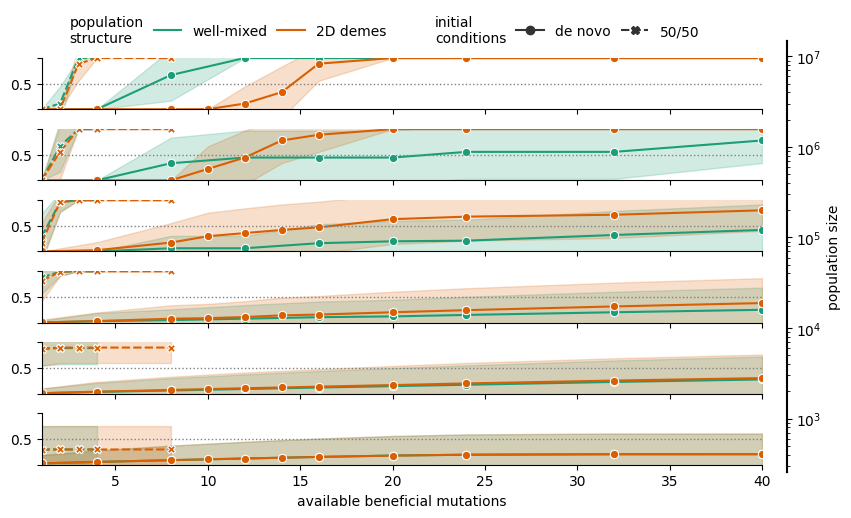

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


teeplots/cupy-traits/errorbar=sd+hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.pdf
teeplots/cupy-traits/errorbar=sd+hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.png


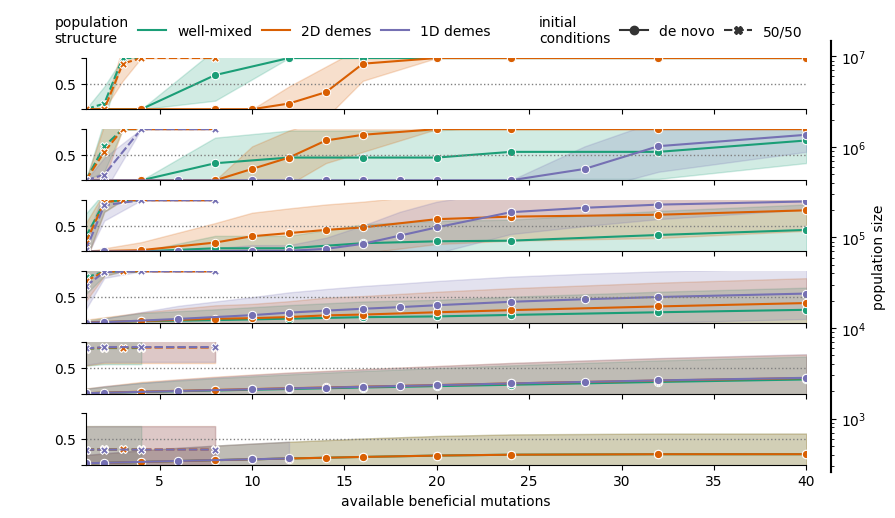

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


teeplots/cupy-traits/errorbar=se+exclude=1D-demes+hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.pdf
teeplots/cupy-traits/errorbar=se+exclude=1D-demes+hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.png


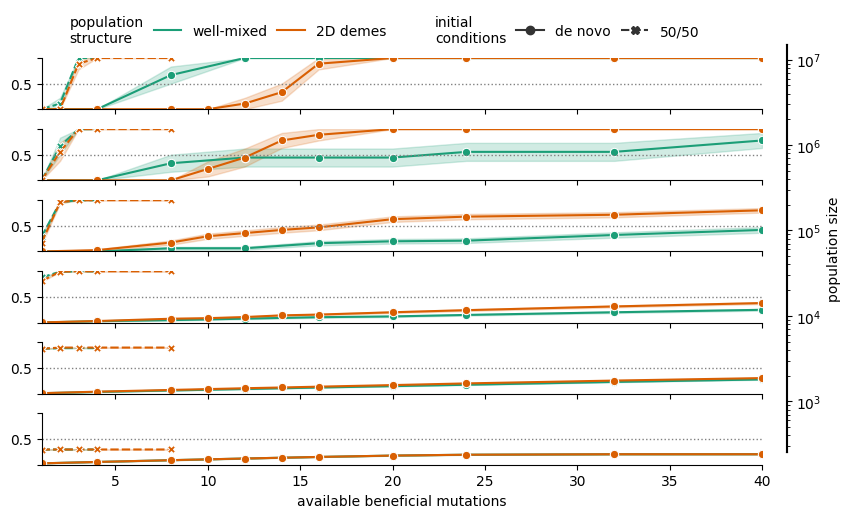

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


teeplots/cupy-traits/errorbar=se+hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.pdf
teeplots/cupy-traits/errorbar=se+hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.png


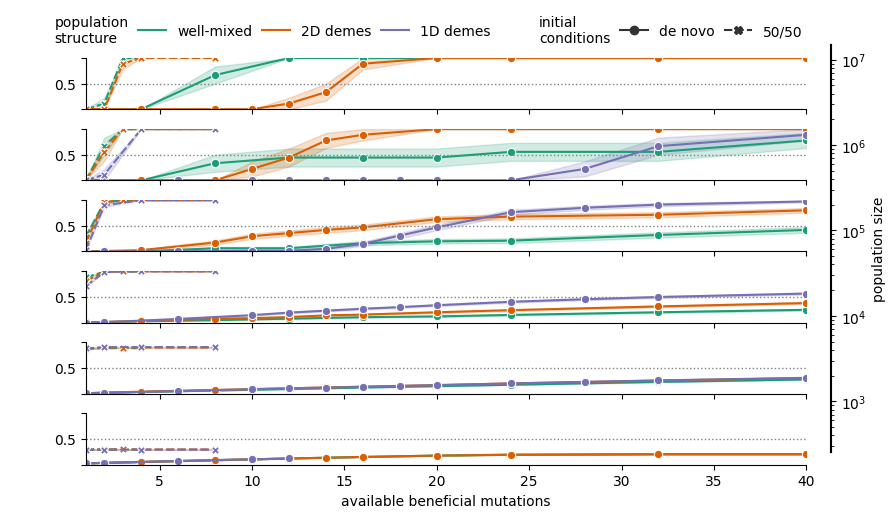

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


teeplots/cupy-traits/errorbar=ci+exclude=1D-demes+hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.pdf
teeplots/cupy-traits/errorbar=ci+exclude=1D-demes+hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.png


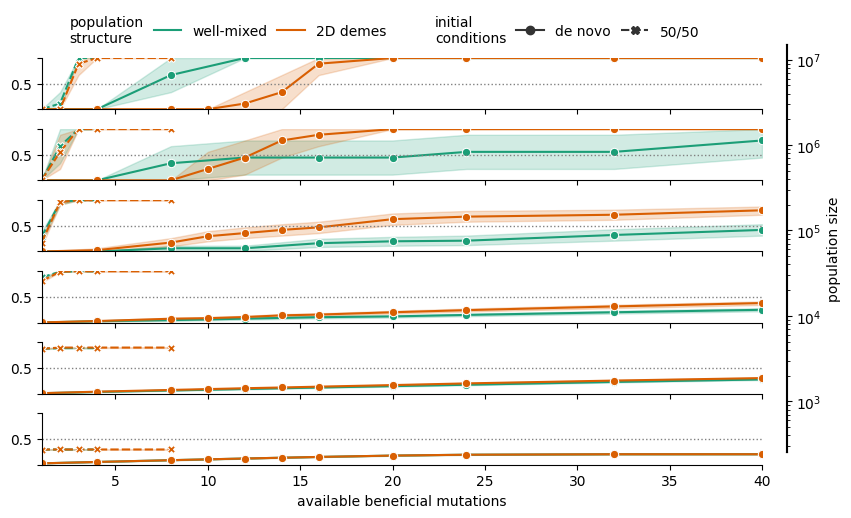

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


teeplots/cupy-traits/errorbar=ci+hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.pdf
teeplots/cupy-traits/errorbar=ci+hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.png


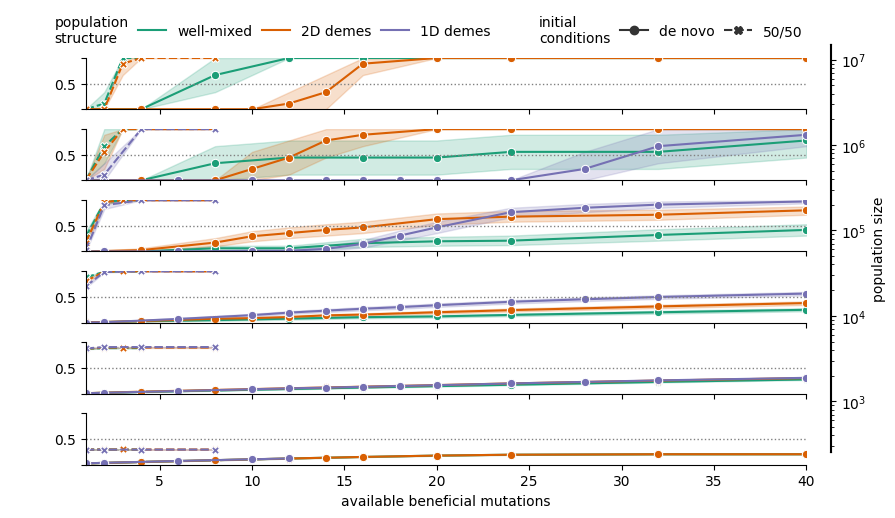

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


teeplots/cupy-traits/exclude=1D-demes+hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.pdf
teeplots/cupy-traits/exclude=1D-demes+hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.png


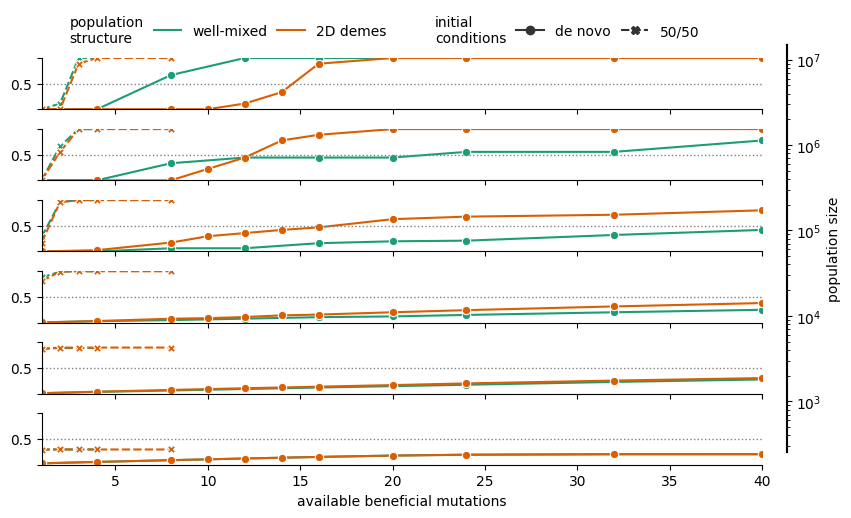

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


teeplots/cupy-traits/hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.pdf
teeplots/cupy-traits/hue=population-structure+kind=line+palette=dark2+row=population-size+style=initial-conditions+viz=relplot+x=available-beneficial-mutations+y=fix-prob+ext=.png


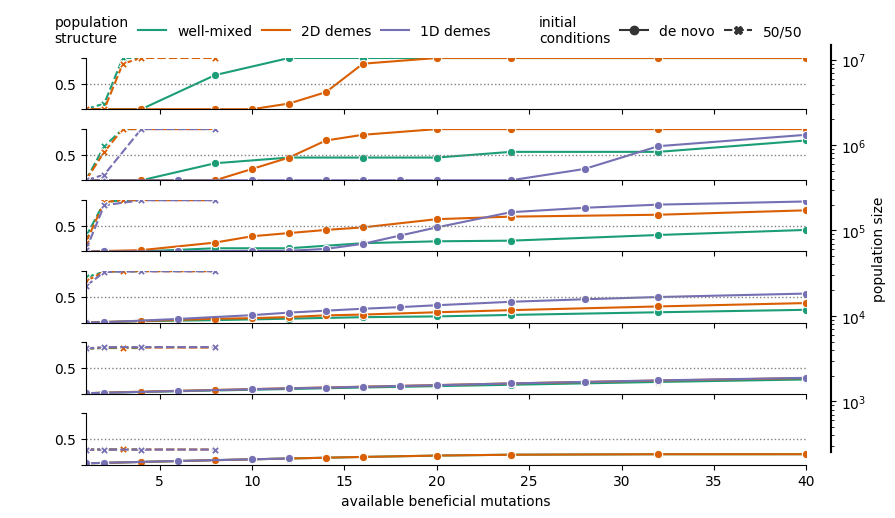

In [6]:
data = dfxs.filter(
    pl.col("genotype") == "hypermutator",
    ~(
        (pl.col("population size") > 1679616)
        & (pl.col("population structure") == "1D demes")
    ),
    ~(
        (pl.col("population size") <= 256)
        & (pl.col("available beneficial mutations") > 12)
        & (pl.col("population structure") == "1D demes")
    ),
).with_columns(
    pl.col("fixation probability").alias("fix\nprob"),
    pl.col("population structure").alias("population\nstructure"),
    pl.col("initial conditions").alias("initial\nconditions"),
)

row = "population size"
for errorbar, exclude in it.product(
    ["sd", "se", "ci", None],
    ["1D demes", None],
):
    with tp.teed(
        sns.relplot,
        data=data.filter(
            pl.col("population structure") != pl.lit(exclude)
            if exclude is not None
            else True,
        ),
        x="available beneficial mutations",
        y="fix\nprob",
        row=row,
        row_order=sorted(
            data[row].to_pandas().unique(), reverse=True
        ),
        hue="population\nstructure",
        hue_order=[
            *filter(
                lambda x: x != exclude,
                ("well-mixed", "2D demes", "1D demes"),
            ),
        ],
        style="initial\nconditions",
        style_order=["de novo", "50/50"],
        aspect=10,
        errorbar=errorbar,
        # facet_kws=dict(margin_titles=True),
        height=0.8,
        kind="line",
        markers=True,
        palette="Dark2",
        seed=1,
        teeplot_subdir=teeplot_subdir,
        teeplot_outattrs=(
            {"exclude": exclude.replace(" ", "-")}
            if exclude is not None
            else {}
        ),
    ) as teed:
        teed.set_titles(
            col_template="",
            row_template="",
        )
        teed.set(ylim=(0, 1), xlim=(1, 40))
        sns.move_legend(
            teed,
            "lower center",
            bbox_to_anchor=(0.4, 0.97),
            frameon=False,
            ncol=7,
            title=None,
            columnspacing=0.7,
        )
        for ax in teed.axes.flat:
            ax.axhline(0.5, ls=":", c="gray", lw=1)
            ax.set_yticks([0, 0.5, 1])
            ax.set_yticklabels(["", "0.5", ""])
            ax.set_ylabel("")

        teed.figure.subplots_adjust(top=0.85)
        delta = 0.001  # Small height for the dummy axis
        pos = teed.axes.flat[0].get_position()
        dummy_ax = ax.figure.add_axes(
            [
                pos.x0 + pos.width,
                pos.y0 - pos.height * data[row].to_pandas().nunique() * 1.9,
                delta,
                pos.height * data[row].to_pandas().nunique() * 2.5,
            ],
        )
        yvals = data[row]
        dummy_ax.set_ylim(yvals.min(), yvals.max())
        dummy_ax.yaxis.set_label_position("right")
        dummy_ax.set_ylabel(row)

        dummy_ax.set_yscale("log")
        dummy_ax.yaxis.set_ticks_position("right")
        dummy_ax.yaxis.set_major_locator(
            mpl_ticker.LogLocator(base=10),
        )
        formatter = mpl_ticker.LogFormatterMathtext(base=10)
        dummy_ax.yaxis.set_major_formatter(formatter)

        # Hide unwanted spines
        dummy_ax.get_xaxis().set_visible(False)

        teed.tight_layout()
